### Predicting SWBC dialogue act labels for utterances 




In [1]:
### Imports

# Standard imports 
from typing import List, Dict, Any
import glob 
import os
from copy import deepcopy
# Third party imports 
from dialog_tag import DialogTag 
import pandas as pd
import numpy as np 
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import itertools


In [2]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
# Mapping between dialogue act tags and their abbreviations.
swbc_tag_mapping = {
    "sd" : "Statement-non-opinion" ,
    "b" : "Acknowledge (Backchannel)",
    "sv" : "Statement-opinion",
    "aa" : "Agree/Acept",
    "% -" : "Abandoned or Turn-Exit",
    "ba" : "Appreciation",
    "qy" : "Yes-No-Question",
    "x" : "Non-verbal" ,
    "ny" : "Yes-answers",
    "fc" : "Conventional-closing",
    "%" : "Uninterpretable",
    "qw" : "Wh-Question",
    "nn" : "No answers",
    "bk" : "Response Acknowledgement",
    "h" : "Hedge",
    "qy^d" : "Declerative Yes-No-Question",
    "o,fo,bc,by,fw" : "Other",
#     "o" : "Other",
#     "fo" : "Other",
#     "bc" : "Other",
#     "by" : "Other",
#     "fw" : "Other",
    "noise" : "Other",
    "bh": "Backchannel in question form",
    "^q" : "Quotation",
    "bf" : "Summerize/reformulate",
    "na,ny^e" : "Affirmative non-yes answers",
#     "na" : "Affirmative non-yes answers",
#     "ny^e" : "Affirmative non-yes answers",
    "ad" : "Action-directive",
    "^2" : "Collaborative Completion",
    "b^m" : "Repeat-phrase",
    "qo" : "Open-Question",
    "qh" : "Rhetorical-Questions",
    "^h" : "Hold before answer/agreement",
    "ar" : "Reject",
    "ng,nn^e": "Negative non-no answers",
#     "ng" : "Negative non-no answers",
#     "nn^e" : "Negative non-no answers", 
    "br" : "Signal-non-understanding",
    "no" : "Other answers",
    "fp" : "Conventional-opening",
    "qrr" : "Or-Clause",
    "arp,nd" : "Dispreferred answers",
    "arp" : "Dispreferred answers",
    "nd" : "Dispreferred answers", 
    "t3" : "3rd-party-talk",
    "oo,cc,co" : "Offers, Options Commits",
#     "oo" : "Offers, Options Commits",
#     "cc" : "Offers, Options Commits",
#     "co" : "Offers, Options Commits",
    "t1" : "Self-talk",
    "bd" : "Downplayer",
    "aap/am" : "Maybe/Accept-part",
    "^g" : "Tag-Question",
    "qw^d" : "Declarative Wh-Question",
    "fa" : "Apology",
    "ft" : "Thanking"   
} 

In [4]:
#### Loading data frames

def load_data_frames_from_directory(dir_path : str) -> Dict[str,pd.DataFrame]:
    """
    Load .csv files from the given directory as pandas dataframes
    
    Args:
        dir_path (str): Path to the directory 
    
    Returns:
        (Dict[str,pd.DataFrame]): 
            Mapping from the file name to the pandas dataframe. 
    """
    data_frames = dict()
    csv_file_paths = glob.glob("{}/*.{}".format(dir_path,"csv"))
    for file_path in csv_file_paths:
        file_name = file_path[file_path.rfind("/")+1:file_path.rfind(".")]
        data_frames[file_name] = load_csv(file_path)
    return data_frames

def load_csv(file_path : str) -> pd.DataFrame:
    """
    Load the .csv file at the given path. 
    
    Args:
        file_path (str): Path of the file. 
    
    Returns:
        (pd.DataFrame)
    """
    return pd.read_csv(file_path, index_col=0) 

def save_data_frames(dir_path : str, data_frames : Dict[str,pd.DataFrame]) -> bool:
    """
    Save the given data frames as csv files.
    
    Args:
        dir_path (str): Path to the output directory 
        data_frames (Dict[str,pd.DataFrame]):
            Mapping from data frame file names to the actual dataframe. 
    
    Returns:
        (bool): True if successful. False otherwise. 
    """
    # If directory does not exist, create it 
    if not os.path.isdir(dir_path):
        os.path.mkdir(dir_path)
    for file_name, data_frame in data_frames.items():
        if not save_csv(dir_path, file_name, data_frame):
            return False 
    return True 

def save_csv(dir_path : str, file_name : str, data_frame : pd.DataFrame) -> bool:
    """
    Save the given dataframe as a csv file. 
    """
    path = "{}/{}.csv".format(dir_path,file_name)
    data_frame.to_csv(path) 
    return True



In [5]:
#### HELPER METHODS

def generate_list(data_frames : List[pd.DataFrame], df_label : str) -> List[Any]:
    """
    Create a list of elements for all data frames that has the given label.
    
    Args:
        data_frames (List[pd.DataFrame])
        df_label (str): Label for the dataframe to put into a list.
    """
    res = list()
    for data_frame in data_frames:
        res.extend(data_frame[df_label])
    return res

In [6]:
#### Metrics methods 

def generate_confusion_matrix(data_frames : List[pd.DataFrame]) -> np.ndarray:
    y = generate_list(data_frames,"tags")
    y_predicted = generate_list(data_frames,"predicted_tags")
    cf = confusion_matrix(y,y_predicted)
    return cf 

def get_accuracy(data_frames : List[pd.DataFrame]) -> float:
    y = generate_list(data_frames,"tags")
    y_predicted = generate_list(data_frames,"predicted_tags")
    return accuracy_score(y,y_predicted)


In [15]:
#### Visualization methods 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [8]:
# Predict the dialogue act tag for every sentence in every dataframe. 

def predict_tags( model : DialogTag, df : pd.DataFrame) ->  pd.DataFrame:
    df = deepcopy(df)
    predicted_tags = list()
    equals = list()
    for i in range(len(df)):
        utterance = df.at[i,"utterances"]
        if df.at[i,"tags"] in swbc_tag_mapping.keys():
            df.at[i,"tags"] = swbc_tag_mapping[df.at[i,"tags"]]
        try:
            predicted_tag = model.predict_tag(utterance)
            predicted_tags.append(predicted_tag)
            equals.append(predicted_tag == df.at[i,"tags"])
        except:
            predicted_tags.append("NAN")
            equals.append(True)
    df["predicted_tags"] = predicted_tags
    df["equals"] = equals
    return df 


In [9]:
# Globals 
TEST_DIR_PATH = "/Users/muhammadumair/Documents/Repositories/mumair01-Repos/repair-tagging/data/pre-processed-swbc"
OUT_DIR_PATH = "/Users/muhammadumair/Documents/Repositories/mumair01-Repos/repair-tagging/data/predicted-tags-swbc"
DIALOGUE_MODEL_TYPE = "distilbert-base-uncased"

In [10]:
# Initializing the dialogue act prediction model
dialogue_act_model = DialogTag(DIALOGUE_MODEL_TYPE)



distilbert-base-uncased found in cache. Loading model...


Some layers from the model checkpoint at /Users/muhammadumair/.dialog-tag/models/distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /Users/muhammadumair/.dialog-tag/models/distilbert-base-uncased and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

In [11]:
# Load in all the test files. 
data_frames = load_data_frames_from_directory(TEST_DIR_PATH)


In [12]:
# Predict the dialogue act tags for every dataframe and save the results. 
# Order of the columns for the dataframe
cols = ["tags","predicted_tags","equals","utterances"]

num_frames_to_use = 2
items = list(data_frames.items())
predicted_frames = dict()

for i in range(num_frames_to_use):
    file_name , data_frame = items[i]
    data_frame = predict_tags(dialogue_act_model, data_frame)
    data_frame = data_frame[cols]
    data_frame.head()
    predicted_frames[file_name] = data_frame
    


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:
# Saving the data frames as a csv 
res = save_data_frames(OUT_DIR_PATH , predicted_frames)
if res:
    print("Dataframes saved successfully")
else:
    print("Dataframes save unsuccessful")


Dataframes saved successfully


In [17]:
# Generating confusion matrix for the classifier 
conf_matrix = generate_confusion_matrix(predicted_frames.values())
accuracy = get_accuracy(predicted_frames.values())



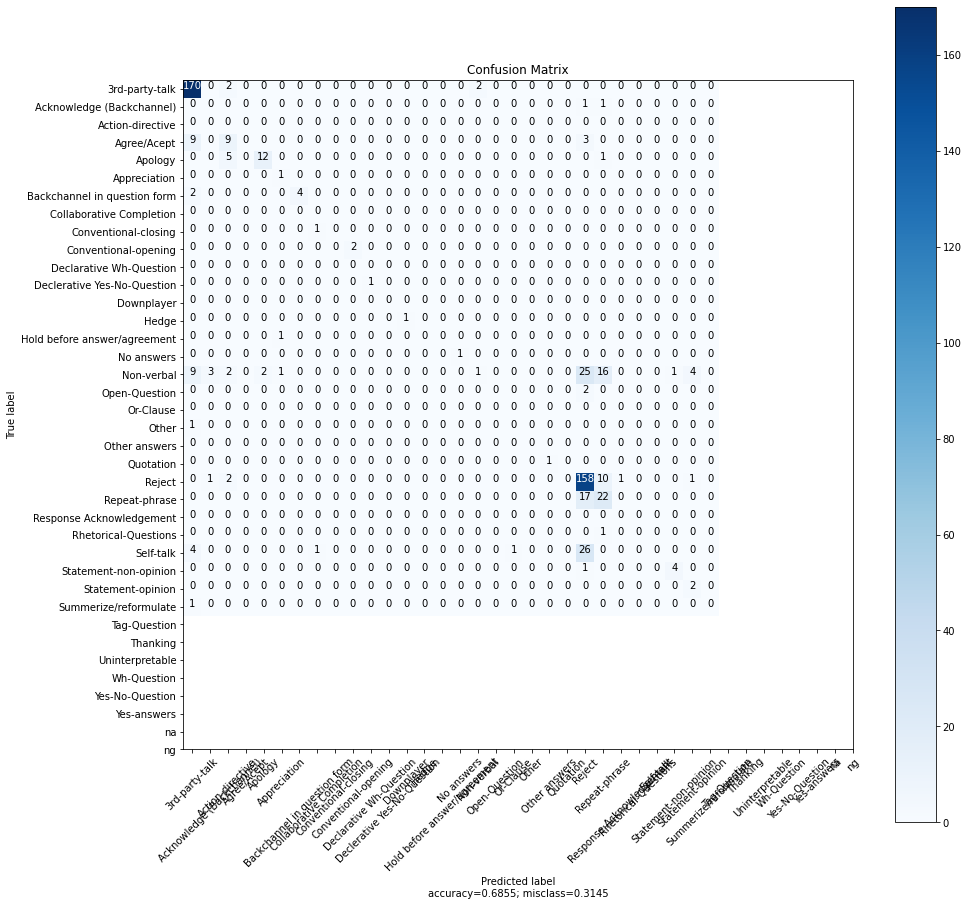

In [28]:
# Visualizing different measures
#display_confusion_matrix(conf_matrix)

#labels = [str(i) for i in range(len(conf_matrix[0]))]

true_labels = list()
for tag in generate_list(data_frames.values(),"tags"):
    if tag in swbc_tag_mapping:
        true_labels.append(swbc_tag_mapping[tag])
    else:
        true_labels.append(tag)
true_labels = np.unique(true_labels)


plot_confusion_matrix(cm = conf_matrix, 
                      normalize    = False,
                      target_names = true_labels,
                      title        = "Confusion Matrix")


